## TokenShift Memory benchmarking

As current TokenShift models, have started to drastically surpass the raven model, this is a varient that focuses on such models

## Setup

In [2]:
# Due to the size of the CSV data, we did not include it in the repository. You can download our current CSV data from hugging face
!mkdir -p ./logs

# Experimental V5 models
!cd ./logs && wget -nc "https://huggingface.co/picocreator/memory-size-experiment-for-rwkv/raw/main/memory-benchmark-logs/BaseV5-C-Tune5.csv"
!cd ./logs && wget -nc "https://huggingface.co/picocreator/memory-size-experiment-for-rwkv/raw/main/memory-benchmark-logs/BaseV5-C-Tune5-4k.csv"

File ‘BaseV5-C-Tune5.csv’ already there; not retrieving.

File ‘BaseV5-C-Tune5-4k.csv’ already there; not retrieving.



In [3]:
# Install required pip libraries
!python -m pip install matplotlib

## Loading of CSV data

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 100)

# # Load the CSV data

v5_1b5_1k  = pd.read_csv("./logs/BaseV5-C-Tune5.csv")
v5_1b5_4k  = pd.read_csv("./logs/BaseV5-C-Tune5-4k.csv")

WN_v5_1b5_1k  = pd.read_csv("./logs/WavenetV5-C-Tune4.csv")
WN_v5_1b5_4k  = pd.read_csv("./logs/WavenetV5-C-Tune4-4k.csv")

In [21]:
# Define a custom function to calculate averages for the first N elements
def calculate_first_n_avg(n, s):
    if(n == -1):
        return s.iloc[:].mean()
    return s.iloc[:n].mean()

# Groupby the 'eval_token_count' and calculate the average for the first 5, 10, and 20 'eval_token_pos'
def group_csv_data(inCSV, modelName):
    grouped_data = inCSV.groupby(['eval_token_count', 'is_random_baseline']).apply(lambda x: pd.Series({
        'First 1 tokens average': calculate_first_n_avg(1, x['eval_token_pos']),
        'First 2 tokens average': calculate_first_n_avg(2, x['eval_token_pos']),
        'First 5 tokens average': calculate_first_n_avg(5, x['eval_token_pos']),
        'First 10 tokens average': calculate_first_n_avg(10, x['eval_token_pos']),
        'First 25 tokens average': calculate_first_n_avg(25, x['eval_token_pos']),
        'First 50 tokens average': calculate_first_n_avg(50, x['eval_token_pos']),
        'First 100 tokens average': calculate_first_n_avg(100, x['eval_token_pos']),
        'First 250 tokens average': calculate_first_n_avg(250, x['eval_token_pos']),
        'First 500 tokens average': calculate_first_n_avg(500, x['eval_token_pos']),
        'First 750 tokens average': calculate_first_n_avg(750, x['eval_token_pos']),
        'First 1000 tokens average': calculate_first_n_avg(1000, x['eval_token_pos']),
        'tokens average position': calculate_first_n_avg(-1, x['eval_token_pos']),
        "match_count": x["matched"].sum(),
        "match_percentage": x["matched"].sum() * 100.0 / x["matched"].count() ,
    })).reset_index()
    grouped_data['model'] = modelName
    return grouped_data

# Merge the DataFrames 
full_grouped_data = pd.concat([
    
    group_csv_data(v5_1b5_1k, 'V5-Baseline 1B5 (L24-D2048)'),
    group_csv_data(v5_1b5_4k, 'V5-Baseline 1B5 (L24-D2048)'),

    group_csv_data(WN_v5_1b5_1k, 'Wavnet-V5 1B5 (L24-D2048)'),
    group_csv_data(WN_v5_1b5_4k, 'Wavnet-V5 1B5 (L24-D2048)'),
])

# Plot the data
full_grouped_data

,eval_token_count,is_random_baseline,First 1 tokens average,First 2 tokens average,First 5 tokens average,First 10 tokens average,First 25 tokens average,First 50 tokens average,First 100 tokens average,First 250 tokens average,First 500 tokens average,First 750 tokens average,First 1000 tokens average,tokens average position,match_count,match_percentage,model
0,5,False,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.000,0.000,0.000000,0.000,0.000000,5.0,100.000000,V5-Baseline 1B5 (L24-D2048)
1,10,False,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.000,0.000,0.000000,0.000,0.000000,10.0,100.000000,V5-Baseline 1B5 (L24-D2048)
2,15,False,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.000,0.000,0.000000,0.000,0.000000,15.0,100.000000,V5-Baseline 1B5 (L24-D2048)
3,20,False,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.000,0.000,0.000000,0.000,0.000000,20.0,100.000000,V5-Baseline 1B5 (L24-D2048)
4,25,False,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.000,0.000,0.000000,0.000,0.000000,25.0,100.000000,V5-Baseline 1B5 (L24-D2048)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,3800,False,16.0,8.0,20.8,269.2,344.52,296.14,201.05,296.660,273.400,354.620000,486.360,579.041579,416.0,10.947368,Wavnet-V5 1B5 (L24-D2048)
55,3850,False,16.0,8.0,37.4,266.9,400.80,332.48,224.00,315.080,293.008,374.246667,508.036,588.709351,396.0,10.285714,Wavnet-V5 1B5 (L24-D2048)
56,3900,False,27.0,13.5,41.2,271.1,393.60,351.20,240.77,327.556,306.466,383.226667,511.275,593.330769,386.0,9.897436,Wavnet-V5 1B5 (L24-D2048)
57,3950,False,37.0,18.5,52.2,272.9,433.48,377.76,273.15,364.900,336.690,409.528000,536.371,603.750886,366.0,9.265823,Wavnet-V5 1B5 (L24-D2048)


In [22]:
# We get the position values, of the average token prediction, withou ONLY the output.
# this helps get the approximate "random" score baseline, while accounting for the fact that the model may eventually notice patterns that makes it not truely random
# (eg. no special characters, etc), as the sample grows.

# # Filter out for noise baseline
random_baseline = full_grouped_data[full_grouped_data['is_random_baseline'] == True]

# # Geet the average first 1000 tokens for all models
# random_baseline_pos = random_baseline.groupby(['model']).mean()['First 1000 tokens average']["Raven 1B5"]
# half_random_base_line_pos = random_baseline_pos / 2

# print("random_baseline_pos", random_baseline_pos)
# print("half_random_base_line_pos", half_random_base_line_pos)

# Get the specialize model randomized baseline
special_random_baseline_pos = random_baseline.groupby(['model']).mean()['First 1000 tokens average']["V5-Baseline 1B5 (L24-D2048)"]
special_half_random_base_line_pos = special_random_baseline_pos / 2

print("special_random_baseline_pos", special_random_baseline_pos)
print("special_half_random_base_line_pos", special_half_random_base_line_pos)

# Give the randomized baseline values
random_baseline

special_random_baseline_pos 970.785
special_half_random_base_line_pos 485.3925


,eval_token_count,is_random_baseline,First 1 tokens average,First 2 tokens average,First 5 tokens average,First 10 tokens average,First 25 tokens average,First 50 tokens average,First 100 tokens average,First 250 tokens average,First 500 tokens average,First 750 tokens average,First 1000 tokens average,tokens average position,match_count,match_percentage,model
67,1000,True,3222.0,1614.5,1516.4,1730.5,1095.04,910.46,912.65,944.716,935.122,973.444000,970.785,970.785,29.0,2.9,V5-Baseline 1B5 (L24-D2048)
67,1000,True,3518.0,3331.5,24297.6,32241.5,37535.08,38672.26,31742.60,15181.676,9263.882,7323.602667,6268.299,6268.299,18.0,1.8,Wavnet-V5 1B5 (L24-D2048)


In [23]:
# Graphing function
def plotGrapData(sizeArr=[2], redline=False):
    # Lets join the size array, to a single str for logging
    sizeStr = ", ".join([str(x) for x in sizeArr])

    # Plot the axis
    fig, ax = plt.subplots(figsize=(15,7)) #

    # Get the highest value for sizeArr
    max_size = max(sizeArr)

    # Filter the data accordingly
    filtered_data = full_grouped_data[full_grouped_data['is_random_baseline'] == False]
    if max_size > 0:
        filtered_data = filtered_data[filtered_data['eval_token_count'] <= max_size]

    # Plot the data, excluding is random baseline = true
    for key, grp in filtered_data.groupby('model'):
        if len(sizeArr) == 1:
            if(sizeArr[0] == -1):
                ax = grp.plot(
                    ax=ax, kind='line', x='eval_token_count', 
                    y=f'tokens average position',
                    
                    label=f'{key}'
                )
            else:
                ax = grp.plot(
                    ax=ax, kind='line', x='eval_token_count', 
                    y=f'First {sizeArr[0]} tokens average', 
                    label=f'{key}'
                )
        else:
            ax = grp.plot(
                ax=ax, kind='line', x='eval_token_count', 
                y=f'First {sizeArr[0]} tokens average', 
                label=f'{key} - First {sizeArr[0]} tokens average'
            )

        if len(sizeArr) >= 2:
            ax = grp.plot(
                ax=ax, kind='line', x='eval_token_count',
                y=f'First {sizeArr[1]} tokens average', 
                label=f'{key} - First {sizeArr[1]} tokens average', linestyle='dashed'
            )

        if len(sizeArr) >= 3:
            ax = grp.plot(ax=ax, kind='line', x='eval_token_count', 
                          y=f'First {sizeArr[2]} tokens average', 
                          label=f'{key} - First {sizeArr[2]} tokens average', linestyle='dotted'
            )

    # # Limit the X axis to max_size
    # if max_size > 0:
    #     ax.set_xlim(0, max_size)

    # Add redline if set
    if redline != False:
        # ax.axhline(y=half_random_base_line_pos, color='r', linestyle='-.', label='50 percent of Raven Randomized baseline')
        ax.axhline(y=special_half_random_base_line_pos, color='r', linestyle=':', label='50 percent of Specialized Model Randomized baseline')

    # Title overwrites?
    if( sizeArr[0] == -1):
        ax.set_title(f'Average position of all tokens in long sequence')
        ax.set_ylabel(f'Average position of all the correct tokens, in sorted probability order')
    else:
        ax.set_title(f'Recall of the first {sizeStr} tokens in long sequence')
        ax.set_ylabel(f'Average position of first {sizeStr} correct tokens, in sorted probability order')
    ax.set_xlabel(f'Prompt Length (tokens, used in long sequence)')

    # Include grid lines - with major, and minor grid
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', linewidth='0.5')
    ax.grid(which='minor', linestyle=':', linewidth='0.5')

## Highscores for each models

In [24]:
# Lets extract all the "high score" for each model
df = full_grouped_data

models = df.model.unique()

results = []
for model in models:
    model_df = df[df.model == model]
    
    # Last highest match_percentage and associated metrics
    match_percs = model_df.match_percentage.sort_values(ascending=False)
    max_match_perc = match_percs.values[0]
    max_match_perc_row = model_df[model_df.match_percentage == max_match_perc]

    # Last highest match_count and associated metrics
    match_counts = model_df.match_count.sort_values(ascending=False)
    max_match_count = match_counts.values[0]
    max_match_count_row = model_df[model_df.match_count == max_match_count]

    # Last match_percentage >= 90 and associated metrics
    flipped_model_df = model_df.sort_values(by=['eval_token_count'], ascending=False)
    for idx, row in flipped_model_df.iterrows():
        if row['match_percentage'] >= 90.0:
            match_90_row = row
            break
            
    results.append({
        'model': model,

        'max%': max_match_perc,
        'max% : input': int(max_match_perc_row.eval_token_count.values[-1]),

        '90% match: input': match_90_row.eval_token_count,
        '90% match: match': match_90_row.match_count,
        '90% match: %': match_90_row.match_percentage,

        'matched: input': int(max_match_count_row.eval_token_count.values[0]),
        'matched: count': int(max_match_count),
        'matched: %': max_match_count_row.match_percentage.values[0]

    }) 
    
results_df = pd.DataFrame(results)
results_df

,model,max%,max% : input,90% match: input,90% match: match,90% match: %,matched: input,matched: count,matched: %
0,V5-Baseline 1B5 (L24-D2048),100.0,350,2150,1938.0,90.139535,2200,1954,88.818182
1,Wavnet-V5 1B5 (L24-D2048),100.0,270,1750,1583.0,90.457143,1900,1584,83.368421


## (optional) Plotting of high level data

In [25]:
# # Lets chart too much data at too many points, so we can get a better idea of the trend
# # before narrowing it down, commented out, unless you really want it
# plotGrapData([1,2])
# plotGrapData([5,10,25])
# plotGrapData([50,100,250])
# plotGrapData([500,750,1000], redline=True)

## Plotting the data points

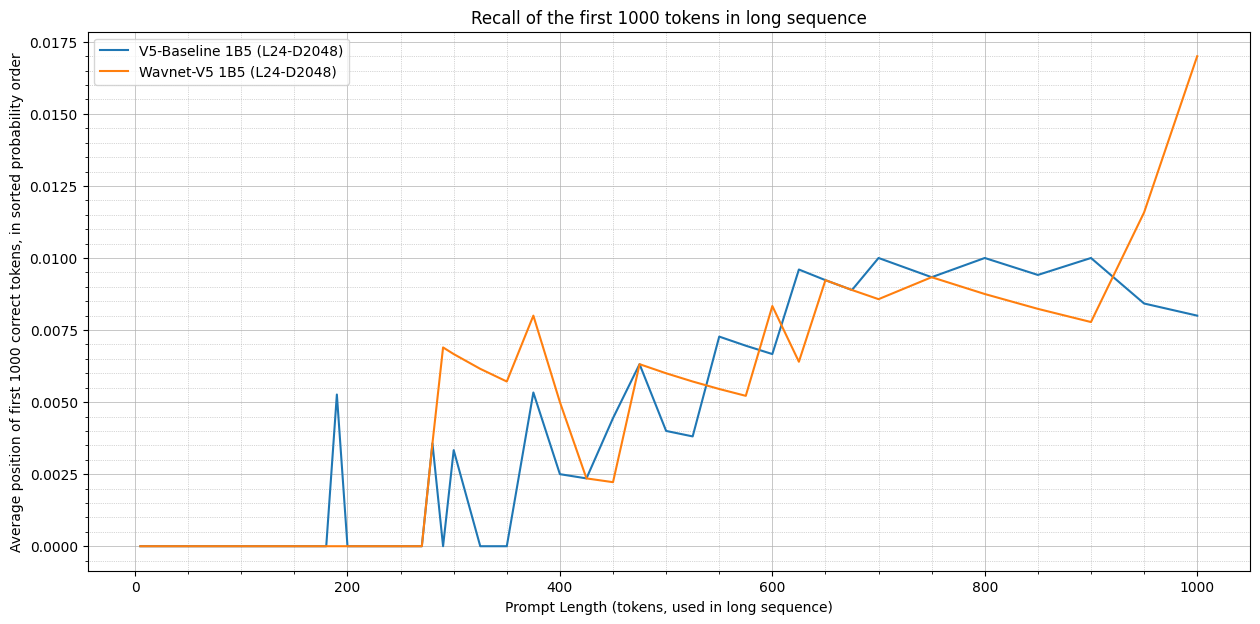

In [26]:
# Lets focus on first 1k
plotGrapData([1000]) #, redline=True

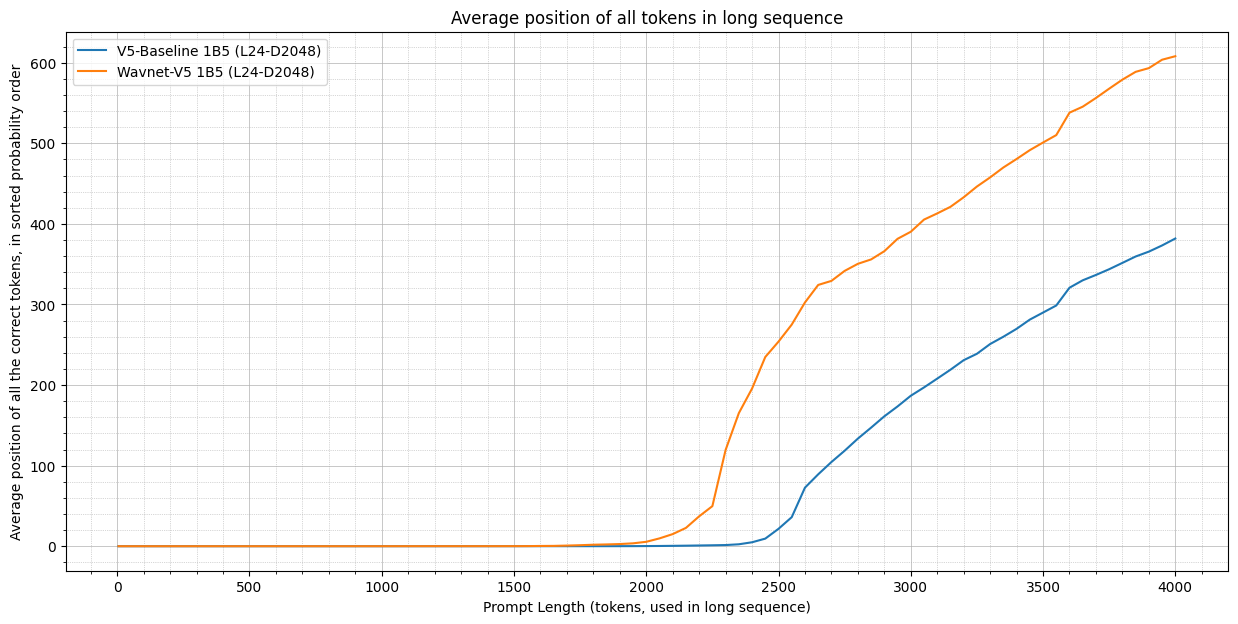

In [27]:
# Lets chart overall average position
plotGrapData([-1]) #, redline=True